# Task 1 - Model Building

#### Import Necessary Libraries

#### Below are the pre-requisite libraries which we need to install, i have commented them after installing them

In [1]:
#pip install matplotlib
#pip install seaborn
#pip install basemap
#pip install sklearn
#pip install mlxtend
#pip install xgboost
#pip install fsspec
#pip install s3fs

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
%matplotlib inline
from sklearn import preprocessing
from mlxtend.classifier import StackingCVClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import random
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, RFE,f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
import pickle
import warnings
warnings.filterwarnings("ignore")

## Subtasks:

## 1. Reading Data
### a.  Reading data from S3 in EC2

In [3]:
train_mobile_brand = pd.read_csv("s3://adcampaignrecommenderdeepaksinghpanwar/train_mobile_brand.csv")
train_mobile_brand.head()

,device_id,gender,age,group_train,phone_brand,device_model
0,-7548291590301750000,M,33,M32+,Huawei,è£è€€3C
1,6943568600617760000,M,37,M32+,Xiaomi,xnote
2,5441349705980020000,M,40,M32+,OPPO,R7s
3,-5393876656119450000,M,33,M32+,Xiaomi,MI 4
4,4543988487649880000,M,53,M32+,samsung,Galaxy S4


In [4]:
df_events_org = pd.read_csv("s3://adcampaignrecommenderdeepaksinghpanwar/train_event_data.csv",dtype={'device_id': np.str, 'latitude': np.float, 'longitude':np.float})
df_events_org.head(n=100)

,device_id,gender,age,group_train,event_id,datetimestamp,latitude,longitude
0,-7548291590301750000,M,33,M32+,2369465.0,2016-05-03 15:55:35,33.98,116.79
1,-7548291590301750000,M,33,M32+,1080869.0,2016-05-03 06:07:16,33.98,116.79
2,-7548291590301750000,M,33,M32+,1079338.0,2016-05-04 03:28:02,33.98,116.79
3,-7548291590301750000,M,33,M32+,1078881.0,2016-05-04 02:53:08,33.98,116.79
4,-7548291590301750000,M,33,M32+,1068711.0,2016-05-03 15:59:35,33.98,116.79
...,...,...,...,...,...,...,...,...
95,-7548291590301750000,M,33,M32+,1941221.0,2016-05-01 18:45:23,33.98,116.79
96,-7548291590301750000,M,33,M32+,1481754.0,2016-05-03 16:08:25,33.98,116.79
97,-7548291590301750000,M,33,M32+,1473446.0,2016-05-01 10:52:20,33.98,116.79
98,-7548291590301750000,M,33,M32+,1473408.0,2016-05-01 10:10:18,33.98,116.79


In [5]:
app_events = pd.read_csv("s3://adcampaignrecommenderdeepaksinghpanwar/app_events.csv")
app_events.head()

,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


In [6]:
app_events_meta_data = pd.read_csv("s3://adcampaignrecommenderdeepaksinghpanwar/app_events_meta_data.csv")
app_events_meta_data.head()

,app_id,label_id,category
0,7324880000000000000.0,251.0,Finance
1,-4494220000000000000.0,251.0,Finance
2,6058200000000000000.0,406.0,unknown
3,6058200000000000000.0,407.0,DS_P2P net loan
4,8694630000000000000.0,406.0,unknown


## 2. Data Cleaning

### a. Example - Geospatial Data (Lat and Long)

In [7]:
df_events = df_events_org[df_events_org['event_id'].notnull()]
df_events.head()

,device_id,gender,age,group_train,event_id,datetimestamp,latitude,longitude
0,-7548291590301750000,M,33,M32+,2369465.0,2016-05-03 15:55:35,33.98,116.79
1,-7548291590301750000,M,33,M32+,1080869.0,2016-05-03 06:07:16,33.98,116.79
2,-7548291590301750000,M,33,M32+,1079338.0,2016-05-04 03:28:02,33.98,116.79
3,-7548291590301750000,M,33,M32+,1078881.0,2016-05-04 02:53:08,33.98,116.79
4,-7548291590301750000,M,33,M32+,1068711.0,2016-05-03 15:59:35,33.98,116.79


### b. Cleaning of Other data requried

Check for missing values: Use the isnull() method to check if there are any missing values in the DataFrame. If there are, you can decide whether to drop the rows with missing values or fill in the missing values with an appropriate value.

In [8]:
# Check for missing values
print(app_events.isnull().sum())

# Drop rows with missing values
app_events.dropna(inplace=True)

# Fill missing values with a specific value
app_events.fillna(value=0, inplace=True)

event_id        0
app_id          0
is_installed    0
is_active       0
dtype: int64


Check for duplicates: Use the duplicated() method to check if there are any duplicate rows in the DataFrame. If there are, you can decide whether to drop the duplicate rows or keep only the first occurrence of each unique row.

In [9]:
# Check for duplicates
print(app_events.duplicated().sum())

# Drop duplicate rows
app_events.drop_duplicates(inplace=True)

# Keep only the first occurrence of each unique row
app_events.drop_duplicates(keep='first', inplace=True)

0


Convert data types: Check the data types of each column in the DataFrame using the dtypes attribute. If any columns have the wrong data type, use the astype() method to convert them to the correct data type.

In [10]:
# Check data types
print(app_events.dtypes)

# Convert a column to a different data type
app_events['event_id'] = app_events['event_id'].astype(str)
app_events['is_active'] = app_events['is_active'].astype(bool)

event_id        int64
app_id          int64
is_installed    int64
is_active       int64
dtype: object


Remove outliers: Use the describe() method to get a summary of the numerical columns in the DataFrame. If there are any outliers, you can remove them using a suitable method such as Z-score or Interquartile Range (IQR)

In [11]:
# Get summary statistics
print(app_events.describe())

             app_id  is_installed
count  3.247307e+07    32473067.0
mean   1.182779e+18           1.0
std    5.360173e+18           0.0
min   -9.221157e+18           1.0
25%   -3.474568e+18           1.0
50%    1.387044e+18           1.0
75%    6.043001e+18           1.0
max    9.222488e+18           1.0


In [12]:
# Convert the date column to a datetime format
df_events['date'] = pd.to_datetime(df_events['datetimestamp'])

## 3. Basic EDA and Visualisation and Feature Engineering 

### 01. Age and Gender Distribution:

#### a. Plot appropriate grpahs that represent the distribution of age and gender in the dataset[Univariate]

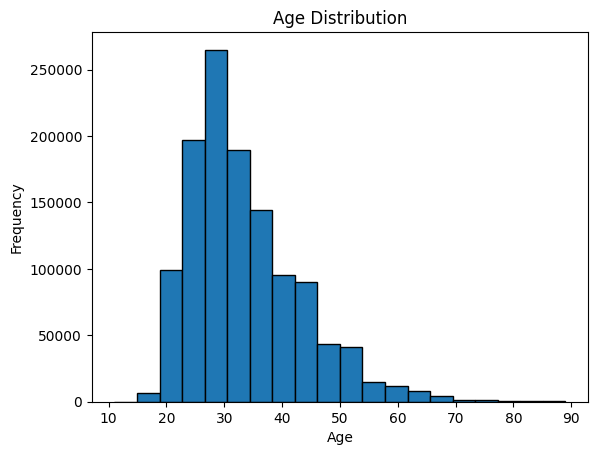

In [13]:
# Plot histogram of age
plt.hist(df_events.age, bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

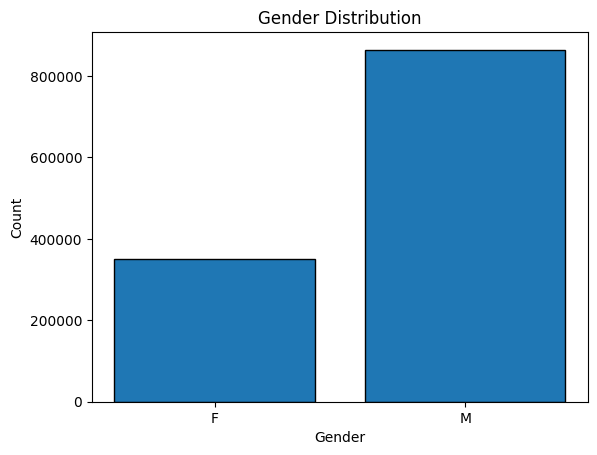

In [14]:
# Plot bar chart of gender
gender_counts = np.unique(df_events.gender, return_counts=True)
plt.bar(gender_counts[0], gender_counts[1], edgecolor='black')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.show()

#### b. Boxplot analysis for gender and age[Bivariate]

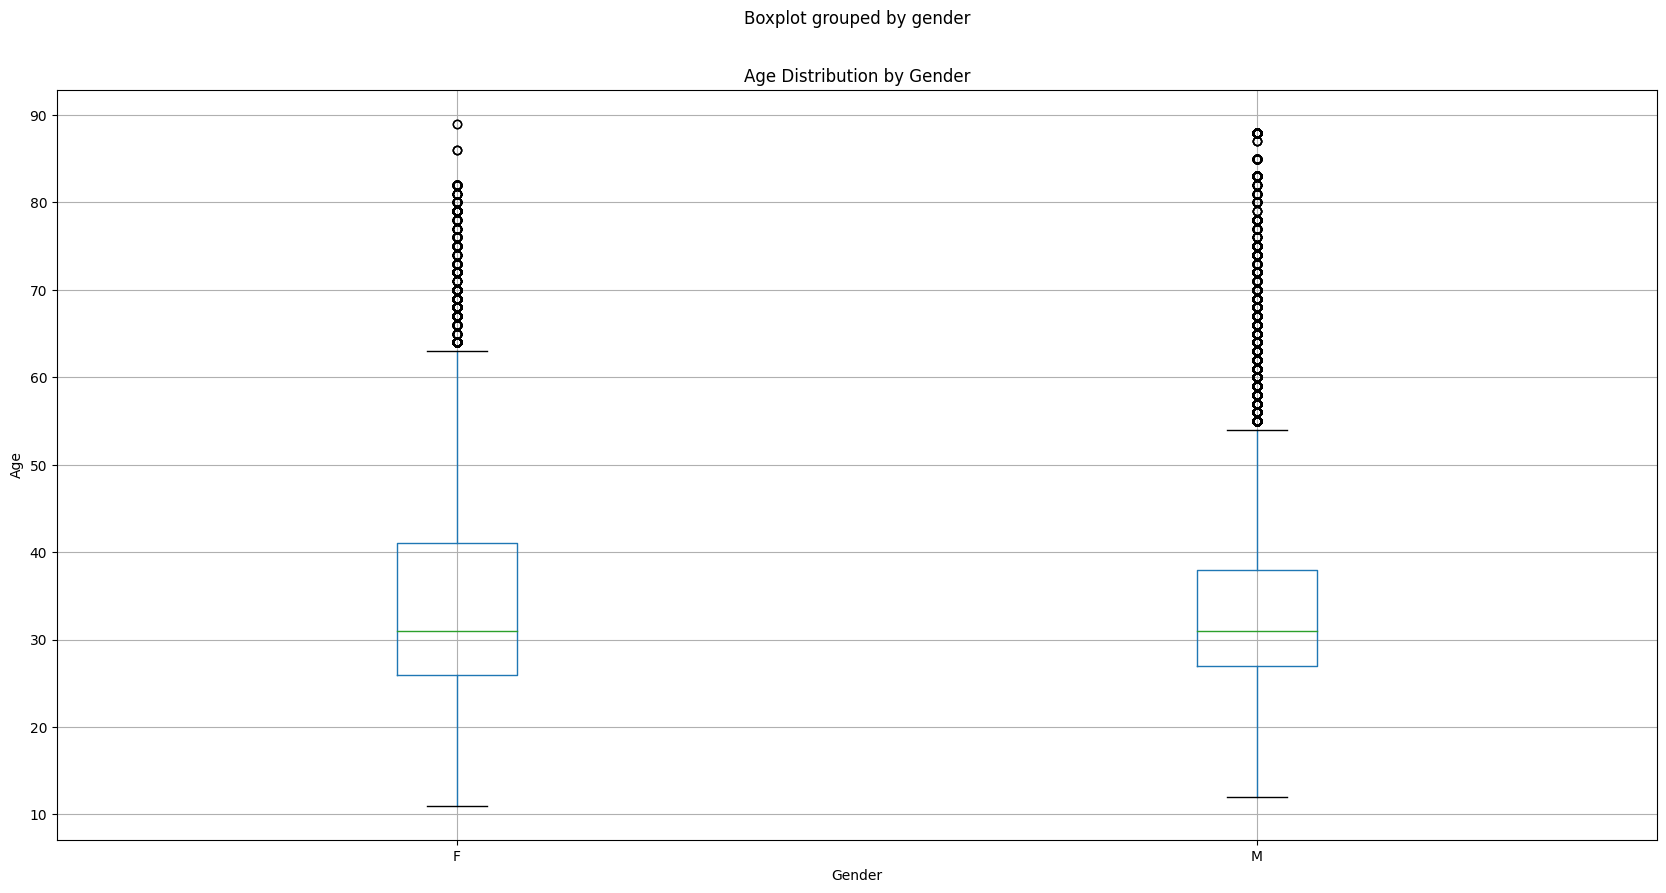

In [15]:
# Create boxplot of age by gender
df_events.boxplot('age', by='gender', figsize=(20,10))
plt.xlabel('Gender')
plt.ylabel('Age')
plt.title('Age Distribution by Gender')
plt.show()

### 02. Trends in Event Data[with respect to devices,days of week,hour,gender and age groups]:

#### a. Plot percentage of device_ids with and without event data

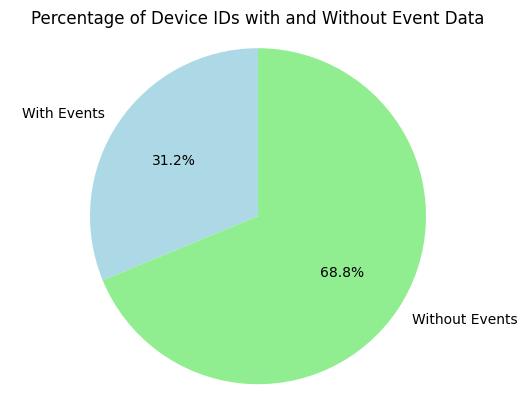

In [16]:
# Calculate the percentage of device_ids with event data
with_events_pct = len(df_events['device_id'].unique()) / len(train_mobile_brand['device_id'].unique()) * 100

# Calculate the percentage of device_ids without event data
without_events_pct = 100 - with_events_pct

# Create a pie chart showing the percentages
labels = ['With Events', 'Without Events']
sizes = [with_events_pct, without_events_pct]
colors = ['lightblue', 'lightgreen']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Device IDs with and Without Event Data')
plt.axis('equal')
plt.show()


#### b. Graph representing the distribution of events on different days of a week

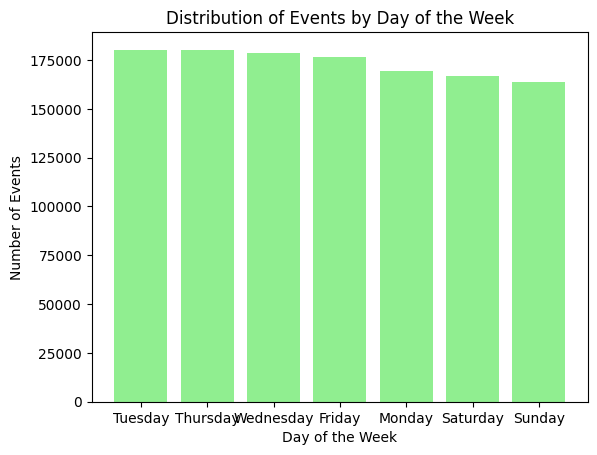

In [17]:
# Convert the date column to a datetime format
df_events['date'] = pd.to_datetime(df_events['datetimestamp'])

# Create a new column for the day of the week
df_events['day_of_week'] = df_events['date'].dt.day_name()

# Count the number of events for each day of the week
day_counts = df_events['day_of_week'].value_counts()

# Create a bar plot showing the distribution of events on different days of the week
plt.bar(day_counts.index, day_counts.values, color='lightgreen')

# Set the title and labels
plt.title('Distribution of Events by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Events')

# Show the plot
plt.show()


#### c. Graph representing the distribution of events per hour[For one week data]

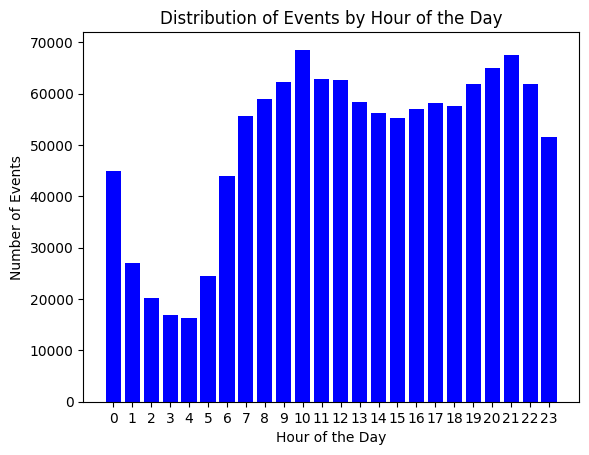

In [18]:
# Convert the date column to a datetime format
df_events['date'] = pd.to_datetime(df_events['datetimestamp'])

# Create a new column for the hour of the day
df_events['hour'] = df_events['date'].dt.hour

# Count the number of events for each hour of the day
hour_counts = df_events['hour'].value_counts().sort_index()

# Create a list of hours with non-zero counts
nonzero_hours = [hour for hour, count in hour_counts.items() if count > 0]

# Filter the hour counts to only include non-zero hours
hour_counts = hour_counts.loc[nonzero_hours]

# Create a line plot showing the distribution of events per hour for the non-zero hours
plt.bar(hour_counts.index, hour_counts.values, color='blue')
# Set the title and labels
plt.title('Distribution of Events by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Events')

# Set the x-axis ticks to show every hour
plt.xticks(np.arange(24))

# Show the plot
plt.show()


#### d. Difference in distribution of events per hour for males and females[Show the difference using appropriate chart for one-week data]

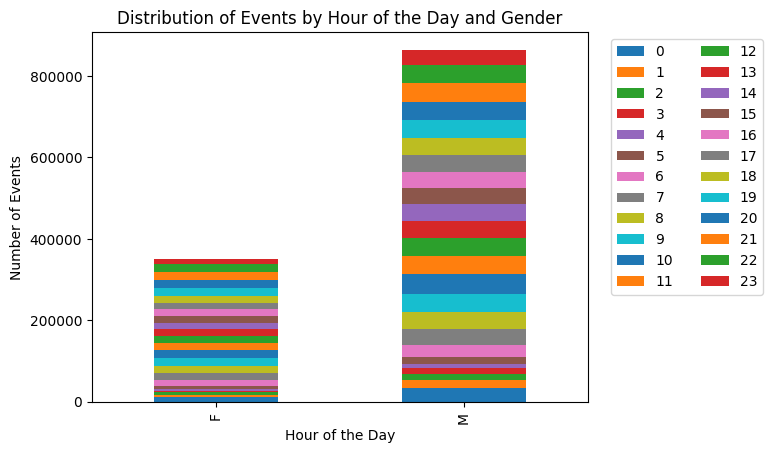

In [19]:

# Create a new column for the hour of the day
df_events['hour'] = df_events['date'].dt.hour

# Group the events by gender and hour, and count the number of events
gender_hour_counts = df_events.groupby([df_events['gender'], df_events['hour']])['event_id'].count().unstack()

# Create a stacked bar chart showing the distribution of events per hour for each gender
ax = gender_hour_counts.plot(kind='bar', stacked=True)

# Set the title and labels
plt.title('Distribution of Events by Hour of the Day and Gender')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Events')

# Set the legend position and size
ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), ncol=2)

# Show the plot
plt.show()


#### e. Is there any difference in the distribution of events for different age groups over different days of a week? [Consider the age groups as 0-24,25-32,33-45,and 46+]

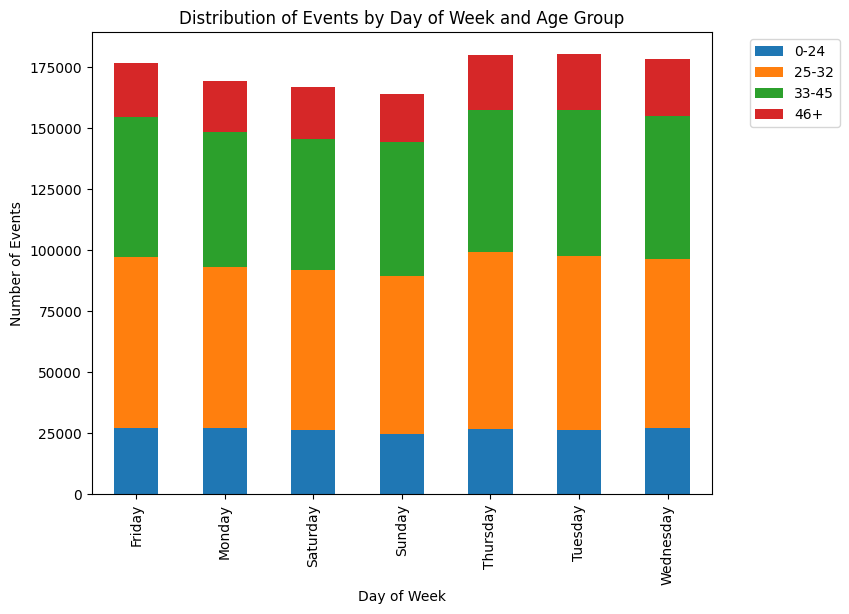

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the age groups
age_groups = ['0-24', '25-32', '33-45', '46+']

# Group the events by day of week and age group
grouped = df_events.groupby([df_events['date'].dt.day_name(), pd.cut(df_events['age'], [0, 24, 32, 45, float('inf')], labels=age_groups)])

# Count the number of events for each group
counts = grouped.size().unstack()

# Plot the results
ax = counts.plot(kind='bar', stacked=True, figsize=(8,6))

# Set the title and axis labels
ax.set_title('Distribution of Events by Day of Week and Age Group')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Number of Events')

# Set the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


#### Yes, We can see the difference in the distribution of events for different age groups over different days of week

### 03. Phone Brand and Application Preferences:

#### a. Stacked bar chart for top 10 mobile brand across male and female customers

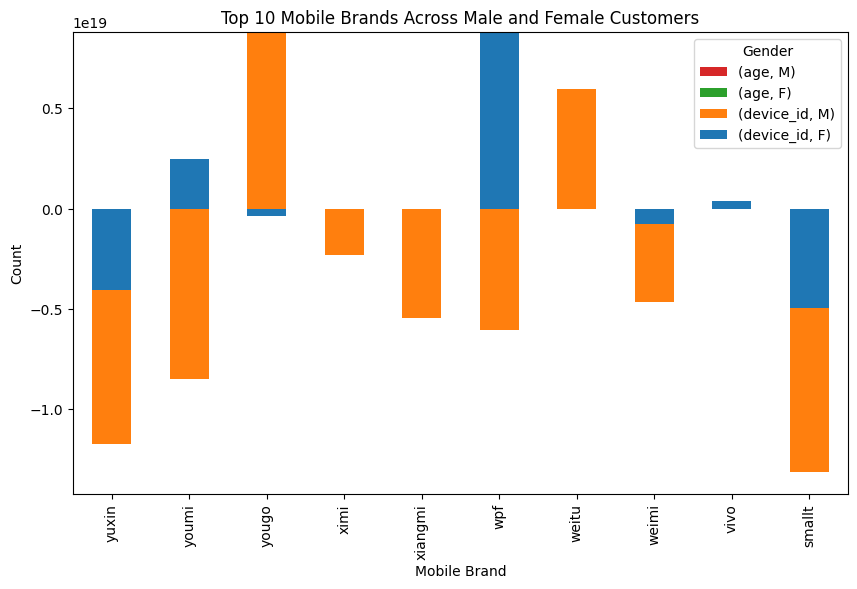

In [21]:
# Group the data by mobile brand and gender, and sum the counts
df_grouped = train_mobile_brand.groupby(['phone_brand', 'gender']).sum().unstack()

df_grouped = df_grouped.sort_values(by='phone_brand', ascending=False).head(10)

# Create a stacked bar chart
ax = df_grouped.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set the title and labels
ax.set_title('Top 10 Mobile Brands Across Male and Female Customers')
ax.set_xlabel('Mobile Brand')
ax.set_ylabel('Count')

# Set the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Gender')

# Show the plot
plt.show()


#### b. Chart representing 10 frequent applications and their respective male and female percentage

In [22]:
df_events_new = df_events.copy()
df_events_new = df_events_new.rename(columns={'device_id': 'app_id'})
df_frequent_apps = pd.concat([df_events_new, app_events_meta_data], axis=1)

In [23]:
df_frequent_apps.head()

,app_id,gender,age,group_train,event_id,datetimestamp,latitude,longitude,date,day_of_week,hour,app_id,label_id,category
0,-7548291590301750000,M,33,M32+,2369465.0,2016-05-03 15:55:35,33.98,116.79,2016-05-03 15:55:35,Tuesday,15,7324880000000000000.0,251.0,Finance
1,-7548291590301750000,M,33,M32+,1080869.0,2016-05-03 06:07:16,33.98,116.79,2016-05-03 06:07:16,Tuesday,6,-4494220000000000000.0,251.0,Finance
2,-7548291590301750000,M,33,M32+,1079338.0,2016-05-04 03:28:02,33.98,116.79,2016-05-04 03:28:02,Wednesday,3,6058200000000000000.0,406.0,unknown
3,-7548291590301750000,M,33,M32+,1078881.0,2016-05-04 02:53:08,33.98,116.79,2016-05-04 02:53:08,Wednesday,2,6058200000000000000.0,407.0,DS_P2P net loan
4,-7548291590301750000,M,33,M32+,1068711.0,2016-05-03 15:59:35,33.98,116.79,2016-05-03 15:59:35,Tuesday,15,8694630000000000000.0,406.0,unknown


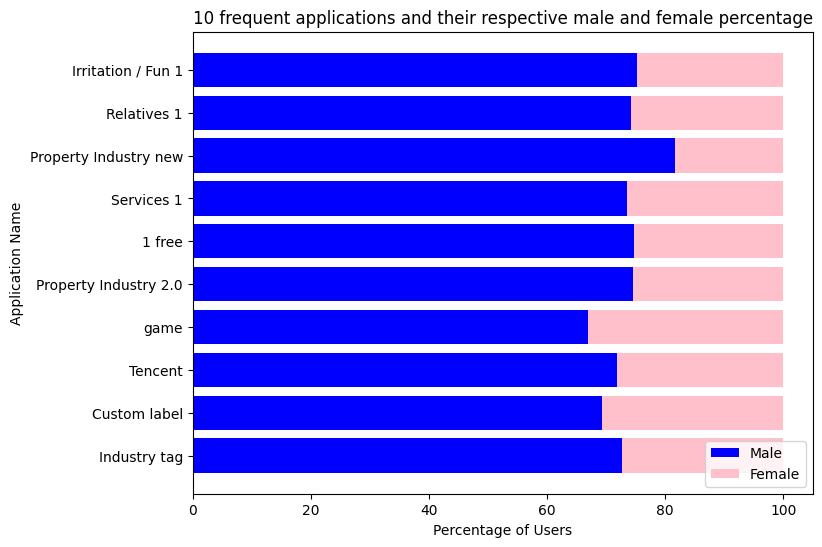

In [24]:
# Load data

# Get top 10 frequent applications
top_apps = df_frequent_apps['category'].value_counts().head(10).index.tolist()

# Calculate percentage of male and female users for each app
app_perc = {}
for app in top_apps:
    app_df = df_frequent_apps[df_frequent_apps['category'] == app]
    total_users = len(app_df)
    male_users = len(app_df[app_df['gender'] == 'M'])
    female_users = len(app_df[app_df['gender'] == 'F'])
    male_perc = male_users / total_users * 100
    female_perc = female_users / total_users * 100
    app_perc[app] = {'male': male_perc, 'female': female_perc}

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['blue', 'pink']
male_data = [app_perc[app]['male'] for app in top_apps]
female_data = [app_perc[app]['female'] for app in top_apps]
y_pos = range(len(top_apps))
ax.barh(y_pos, male_data, color=colors[0], label='Male')
ax.barh(y_pos, female_data, left=male_data, color=colors[1], label='Female')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_apps)
ax.set_xlabel('Percentage of Users')
ax.set_ylabel('Application Name')
ax.legend(loc='lower right')
ax.set_title('10 frequent applications and their respective male and female percentage')
plt.show()


#### c. Top 10 mobile phone brands by age groups [Consider the age groups as 0-24,25-32,33-45 and 46+]

In [25]:
df_top10_mobile_brands = pd.concat([df_events, train_mobile_brand], axis=1)

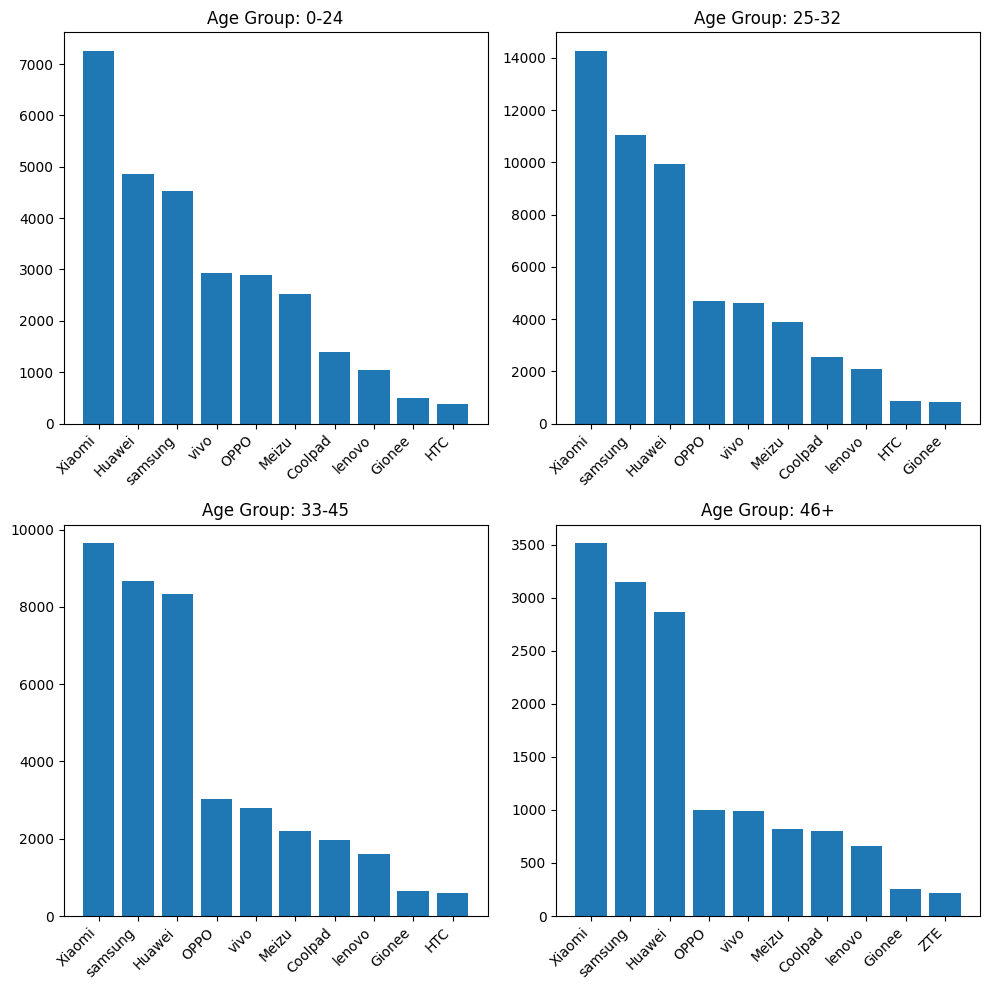

In [26]:
import matplotlib.pyplot as plt

# Define the age groups
age_groups = [
    {'name': '0-24', 'min_age': 0, 'max_age': 24},
    {'name': '25-32', 'min_age': 25, 'max_age': 32},
    {'name': '33-45', 'min_age': 33, 'max_age': 45},
    {'name': '46+', 'min_age': 46, 'max_age': None}
]

# Filter the data by age groups and count the occurrences of each brand
brand_counts_by_age_group = {}
for age_group in age_groups:
    age_filter = (df_top10_mobile_brands['age'] >= age_group['min_age']) & (df_top10_mobile_brands['age'] <= age_group['max_age'] if age_group['max_age'] is not None else True)
    filtered_data = df_top10_mobile_brands.loc[age_filter.values]
    brand_counts = filtered_data['phone_brand'].value_counts().head(10)
    brand_counts_by_age_group[age_group['name']] = brand_counts

# Create the bar plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i, age_group in enumerate(age_groups):
    brands = brand_counts_by_age_group[age_group['name']]
    axs[i].bar(brands.index, brands.values)
    axs[i].set_title(f"Age Group: {age_group['name']}")
    axs[i].set_xticklabels(brands.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()


### Feature Engineering

#### Average number of events per device ID:

In [27]:
# Calculate the average number of events per device ID
avg_events_per_id = df_events.groupby('device_id')['event_id'].count().mean()
avg_events_per_id

52.14920634920635

#### Percentage of time the mobile phone was active by calculating the number of events for a device ID:

In [28]:
# Convert the datetimestamp column to a pandas datetime series
df_events['datetimestamp'] = pd.to_datetime(df_events['datetimestamp'])

# Calculate the total number of events and duration for each device ID
device_events = df_events.groupby('device_id').agg({'event_id': 'count', 'datetimestamp': lambda x: x.max() - x.min()})

# Calculate the percentage of time the mobile phone was active
device_events['active_percentage'] = device_events['event_id'] / ((device_events['datetimestamp'].dt.total_seconds() / 60) * 1440) * 100
device_events

,event_id,datetimestamp,active_percentage
device_id,,,
-1001337759327040000,109,3 days 22:07:00,0.001340
-1002595372059170000,7,1 days 00:09:57,0.000335
-1002733576670970000,55,6 days 15:19:36,0.000400
-1002969456091700000,7,6 days 12:59:34,0.000052
-1005411102947240000,44,2 days 08:49:50,0.000896
...,...,...,...
997893466461332000,7,4 days 00:55:49,0.000084
998208026013018000,71,6 days 04:40:35,0.000553
998402647311351000,4,0 days 01:24:26,0.003290


#### Difference in latitudes and longitudes over a morning period versus the evening and the night periods:

In [29]:
# Calculate the morning, evening, and night periods
morning = ((df_events['datetimestamp'].dt.hour >= 6) & (df_events['datetimestamp'].dt.hour <= 12))
evening = ((df_events['datetimestamp'].dt.hour >= 13) & (df_events['datetimestamp'].dt.hour <= 18))
night = ((df_events['datetimestamp'].dt.hour >= 19) | (df_events['datetimestamp'].dt.hour <= 5))

# Calculate the difference in latitudes and longitudes for each device ID during each period
df_morning = df_events[morning].groupby('device_id').agg({'latitude': lambda x: x.max() - x.min(), 'longitude': lambda x: x.max() - x.min()})
df_evening = df_events[evening].groupby('device_id').agg({'latitude': lambda x: x.max() - x.min(), 'longitude': lambda x: x.max() - x.min()})
df_night = df_events[night].groupby('device_id').agg({'latitude': lambda x: x.max() - x.min(), 'longitude': lambda x: x.max() - x.min()})


In [30]:
df_morning

,latitude,longitude
device_id,,
-1001337759327040000,0.83,0.83
-1002595372059170000,0.00,0.00
-1002733576670970000,0.00,0.00
-1002969456091700000,0.00,0.00
-1006244095847670000,0.00,0.00
...,...,...
996163203858940000,0.00,0.00
997893466461332000,0.00,0.00
998208026013018000,32.02,120.85


In [31]:
df_evening

,latitude,longitude
device_id,,
-1001337759327040000,0.09,0.09
-1002595372059170000,0.00,0.00
-1002733576670970000,37.79,112.59
-1002969456091700000,0.00,0.00
-1005411102947240000,30.62,114.40
...,...,...
99479029389286800,0.00,0.00
994957985493748000,0.00,0.00
997893466461332000,0.00,0.00


In [32]:
df_night

,latitude,longitude
device_id,,
-1002595372059170000,0.00,0.00
-1002733576670970000,37.79,112.59
-1002969456091700000,0.00,0.00
-1005411102947240000,30.62,114.40
-1006244095847670000,0.00,0.00
...,...,...
994957985493748000,0.00,0.00
997893466461332000,0.00,0.00
998208026013018000,0.00,0.00


#### Median latitude and longitude over a period of different events per device ID:

In [33]:
# Calculate the median latitude and longitude for each device ID
median_lat = df_events.groupby('device_id')['latitude'].median()
median_long = df_events.groupby('device_id')['longitude'].median()


In [34]:
median_lat

device_id
-1001337759327040000    30.20
-1002595372059170000     0.00
-1002733576670970000     0.00
-1002969456091700000     0.00
-1005411102947240000    30.62
                        ...  
997893466461332000       0.00
998208026013018000       0.00
998402647311351000      48.50
999208698621622000      27.82
99976251796408100        0.00
Name: latitude, Length: 23310, dtype: float64

In [35]:
median_long

device_id
-1001337759327040000    120.11
-1002595372059170000      0.00
-1002733576670970000      0.00
-1002969456091700000      0.00
-1005411102947240000    114.40
                         ...  
997893466461332000        0.00
998208026013018000        0.00
998402647311351000      128.72
999208698621622000      114.38
99976251796408100         0.00
Name: longitude, Length: 23310, dtype: float64

#### Grouping app categories:

In [36]:
# count the number of unique categories in the dataframe
num_categories = len(app_events_meta_data['category'].unique())
print(f'There are {num_categories} unique categories in the dataframe')

# group the data by category and count the number of apps in each category
grouped_data = app_events_meta_data.groupby('category').count()['app_id']
grouped_data

There are 556 unique categories in the dataframe


category
1 free                19083
1 reputation             90
1 vitality              276
3 kindom game           157
80s Japanese comic      150
                      ...  
violence comic           58
vitality                295
war chess                13
weibo                    67
zombies game            116
Name: app_id, Length: 555, dtype: int64

## 4. Advanced Visualisation and Clustering

###  a. Geospatial Visualization

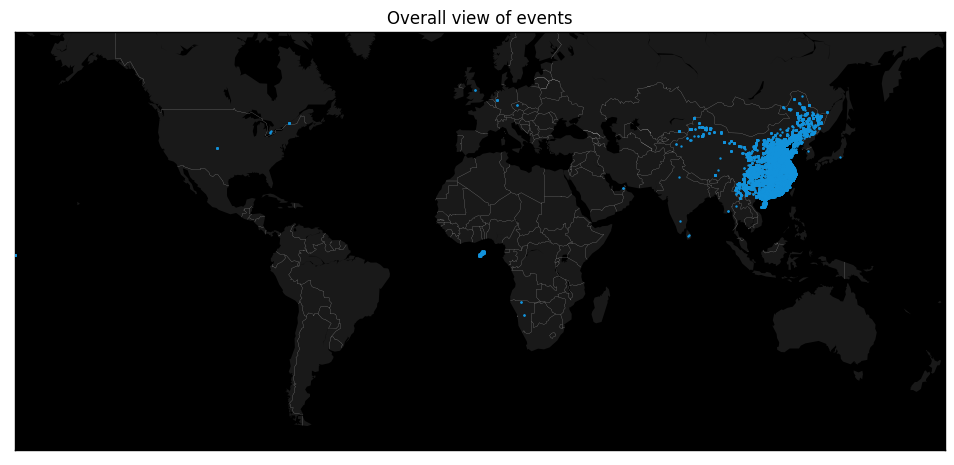

In [37]:
# set up plot
df_events_sample = df_events.sample(n=100000)
plt.figure(1, figsize=(12,6))

#Meractor of World
m1 = Basemap(projection='merc',
             llcrnrlat = -60,
             urcrnrlat=65,
             llcrnrlon=-180,
             urcrnrlon=180,
             lat_ts=0,
             resolution='c')

m1.fillcontinents(color='#191919', lake_color='#000000') #dark grey land, black lakes
m1.drawmapboundary(fill_color='#000000') # balck background
m1.drawcountries(linewidth=0.1, color='w') #thin white line for country borders

#Plot the data
mxy = m1(df_events_sample["longitude"].tolist(), df_events_sample["latitude"].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=1, zorder=5)

plt.title("Overall view of events")
plt.show()

In [38]:
df_0 = df_events[(df_events["longitude"] ==0) & (df_events["latitude"] ==0)]
df_0_around = df_events[(df_events["longitude"] > -1) & \
                   (df_events["longitude"] < 1) &\
                   (df_events["latitude"] >-1) &\
                   (df_events["latitude"] <1)]

print(len(df_events))
print(len(df_0))
print(len(df_0_around))

1215598
356157
356570


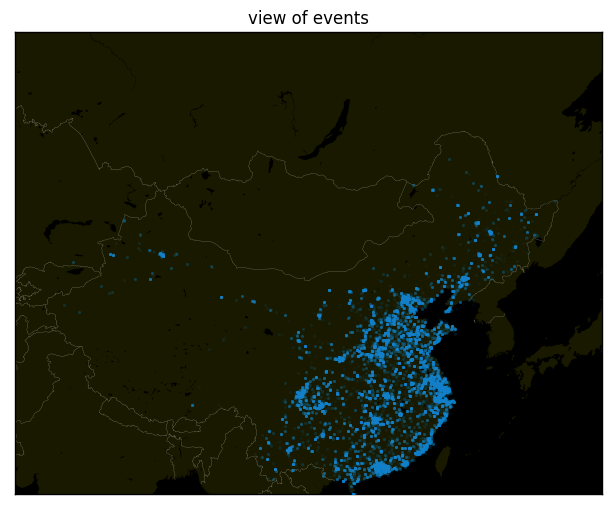

In [39]:
#specific region
lon_min, lon_max = 70, 140
lat_min, lat_max = 20, 60

idx = (df_events["longitude"] > lon_min) &\
      (df_events["longitude"] < lon_max) &\
      (df_events["latitude"] > lat_min) &\
      (df_events["latitude"] < lat_max)
df_events_sample = df_events[idx].sample(n=100000)
plt.figure(2, figsize=(12,6))

m2 = Basemap(projection='merc',
             llcrnrlat = lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='i')

m2.fillcontinents(color='#191900', lake_color='#000000') #dark grey land, black lakes
m2.drawmapboundary(fill_color='#000000') # balck background
m2.drawcountries(linewidth=0.1, color='w') #thin white line for country borders

#Plot the data
mxy = m2(df_events_sample["longitude"].tolist(), df_events_sample["latitude"].tolist())
m2.scatter(mxy[0], mxy[1], s=5, c="#1292db", lw=0, alpha=0.05, zorder=5)

plt.title("view of events")
plt.show()

### Visualization for Male

In [40]:
df_male = df_events_sample[df_events_sample["gender"]=="M"]
df_male

,device_id,gender,age,group_train,event_id,datetimestamp,latitude,longitude,date,day_of_week,hour
771407,-5821716319485760000,M,27,M25-32,2002264.0,2016-05-02 16:59:19,47.61,126.10,2016-05-02 16:59:19,Monday,16
463847,8859850364207260000,M,36,M32+,2462345.0,2016-05-06 20:14:50,39.13,117.16,2016-05-06 20:14:50,Friday,20
47758,-1076279644989310000,M,25,M25-32,2029553.0,2016-05-05 17:27:30,23.32,116.35,2016-05-05 17:27:30,Thursday,17
356097,-1265977982410880000,M,30,M25-32,2980632.0,2016-05-06 19:01:59,37.04,118.43,2016-05-06 19:01:59,Friday,19
634207,-1448078833416770000,M,34,M32+,2969260.0,2016-05-06 08:59:59,26.43,111.61,2016-05-06 08:59:59,Friday,8
...,...,...,...,...,...,...,...,...,...,...,...
511267,5543372423482230000,M,43,M32+,2386458.0,2016-05-07 05:02:55,37.07,111.56,2016-05-07 05:02:55,Saturday,5
182892,3724654925765150000,M,48,M32+,1811168.0,2016-05-05 20:11:43,41.86,123.80,2016-05-05 20:11:43,Thursday,20
885610,5826348067262500000,M,35,M32+,1213904.0,2016-05-05 22:24:50,22.99,113.90,2016-05-05 22:24:50,Thursday,22
191584,8759274431511730000,M,22,M0-24,3149162.0,2016-05-01 19:25:23,37.77,112.54,2016-05-01 19:25:23,Sunday,19


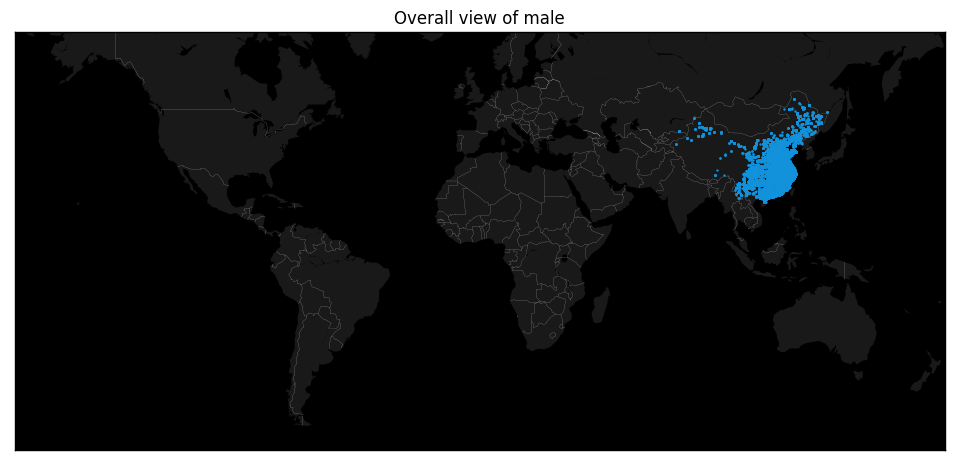

In [41]:
plt.figure(1, figsize=(12,6))

m1 = Basemap(projection='merc',
             llcrnrlat = -60,
             urcrnrlat=65,
             llcrnrlon=-180,
             urcrnrlon=180,
             lat_ts=0,
             resolution='c')

m1.fillcontinents(color='#191919', lake_color='#000000') #dark grey land, black lakes
m1.drawmapboundary(fill_color='#000000') # balck background
m1.drawcountries(linewidth=0.1, color='w') #thin white line for country borders

#Plot the data
mxy = m1(df_male["longitude"].tolist(), df_male["latitude"].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=1, zorder=5)

plt.title("Overall view of male")
plt.show()

### Visualization for Female

In [42]:
df_female = df_events_sample[df_events_sample["gender"]=="F"]
df_female

,device_id,gender,age,group_train,event_id,datetimestamp,latitude,longitude,date,day_of_week,hour
456384,295685201038338000,F,26,F25-32,1713875.0,2016-05-04 11:04:35,34.31,108.95,2016-05-04 11:04:35,Wednesday,11
753031,-7500045804733750000,F,28,F25-32,2767699.0,2016-05-05 00:32:00,30.76,108.44,2016-05-05 00:32:00,Thursday,0
372286,-8320233521923960000,F,27,F25-32,860264.0,2016-05-06 18:03:20,43.86,125.24,2016-05-06 18:03:20,Friday,18
461320,928286868482112000,F,28,F25-32,1023936.0,2016-05-06 21:24:29,29.37,113.12,2016-05-06 21:24:29,Friday,21
770349,8402632590848750000,F,24,F0-24,1511244.0,2016-05-02 08:40:44,30.63,104.04,2016-05-02 08:40:44,Monday,8
...,...,...,...,...,...,...,...,...,...,...,...
970523,2384636672126040000,F,38,F32+,1059451.0,2016-05-01 09:26:24,28.25,112.98,2016-05-01 09:26:24,Sunday,9
393063,1832457339380890000,F,24,F0-24,1279481.0,2016-05-07 10:28:47,24.85,118.62,2016-05-07 10:28:47,Saturday,10
965659,1999051376221720000,F,49,F32+,2076810.0,2016-05-03 09:17:22,34.60,113.52,2016-05-03 09:17:22,Tuesday,9
206720,-7275422412456760000,F,24,F0-24,2941381.0,2016-05-07 11:49:22,27.09,114.91,2016-05-07 11:49:22,Saturday,11


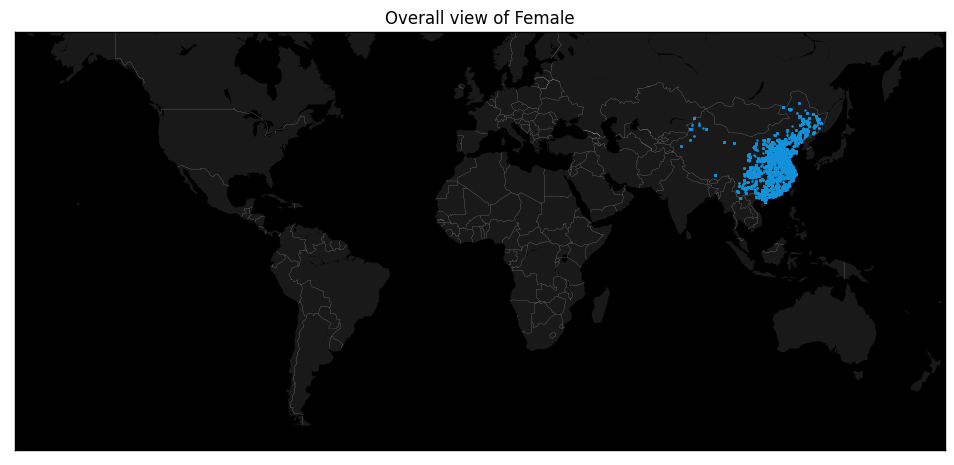

In [43]:
plt.figure(1, figsize=(12,6))

m1 = Basemap(projection='merc',
             llcrnrlat = -60,
             urcrnrlat=65,
             llcrnrlon=-180,
             urcrnrlon=180,
             lat_ts=0,
             resolution='c')

m1.fillcontinents(color='#191919', lake_color='#000000') #dark grey land, black lakes
m1.drawmapboundary(fill_color='#000000') # balck background
m1.drawcountries(linewidth=0.1, color='w') #thin white line for country borders

#Plot the data
mxy = m1(df_female["longitude"].tolist(), df_female["latitude"].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=1, zorder=5)

plt.title("Overall view of Female")
plt.show()

### b. DBSCAN Clustering as a preprocessing Technique

In [44]:
df_events_location = df_events.loc[(df_events['latitude'] != 0) & (df_events['longitude'] != 0), ['latitude', 'longitude']]

In [45]:
# scale the data
scaler = StandardScaler()
df_events_location_scaled = scaler.fit_transform(df_events_location)

In [46]:
df_events_location_scaled = pd.DataFrame(df_events_location_scaled)
df_events_location_scaled.columns = ['F1', 'F2']
df_events_location_scaled.head()

,F1,F2
0,0.379133,0.267618
1,0.379133,0.267618
2,0.379133,0.267618
3,0.379133,0.267618
4,0.379133,0.267618


In [47]:
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(df_events_location_scaled)
distances, indices = nbrs.kneighbors(df_events_location_scaled)
print(np.shape(distances))
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(df_events_location_scaled)
distances, indices = neighbors_fit.kneighbors(df_events_location_scaled)

(859293, 4)


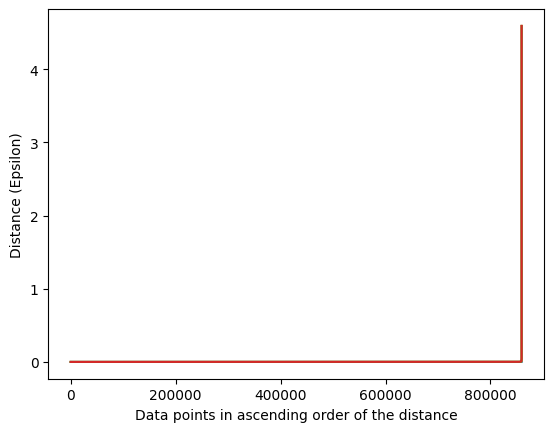

In [48]:
distances = np.sort(distances, axis=0)
plt.plot(distances)
plt.ylabel("Distance (Epsilon)")
plt.xlabel("Data points in ascending order of the distance")
plt.show()


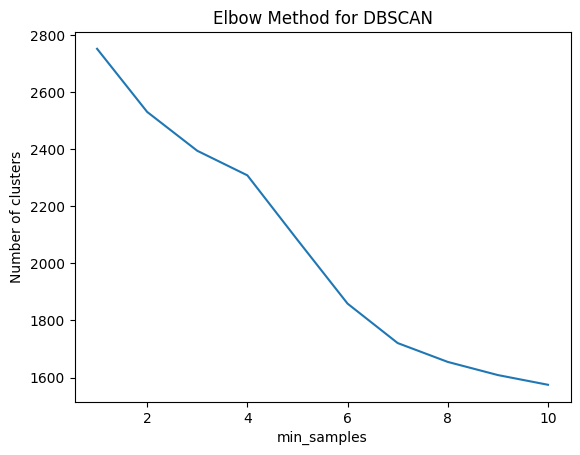

In [49]:
# create a range of min_samples values to test
min_samples_range = range(1, 11)
# perform DBSCAN clustering
# calculate the number of clusters for each min_samples value
num_clusters = []
for min_samples in min_samples_range:
    dbscan = dbscan = DBSCAN(eps=0.1, min_samples=min_samples)
    dbscan.fit(df_events_location)
    num_clusters.append(len(np.unique(dbscan.labels_)))

# plot the number of clusters against min_samples
plt.plot(min_samples_range, num_clusters)
plt.xlabel('min_samples')
plt.ylabel('Number of clusters')
plt.title('Elbow Method for DBSCAN')
plt.show()

In [50]:
# perform DBSCAN clustering
kms_per_radian = 6371.0088
epsilon = 4.8/kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=7, algorithm='ball_tree', metric='haversine').fit(df_events_location_scaled)
labels = db.labels_

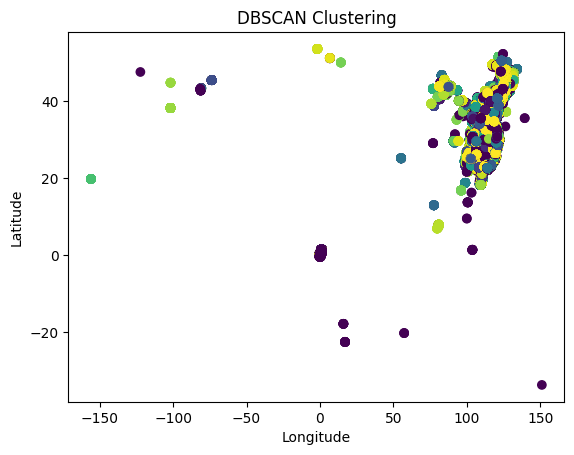

In [51]:
# visualize the clusters
plt.scatter(df_events_location['longitude'], df_events_location['latitude'], c=labels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering')
plt.show()

###  c. Final data preparation and train-test-split

In [52]:
# Convert the phone_brand and device_model columns to categorical features
df_events_sample = pd.concat([df_events_sample, pd.get_dummies(df_events_sample["day_of_week"])], axis=1)

In [53]:
df_events_sample = df_events_sample.drop(['datetimestamp','date','day_of_week'], axis=1)

In [54]:
df_events_sample.head()

,device_id,gender,age,group_train,event_id,latitude,longitude,hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
771407,-5821716319485760000,M,27,M25-32,2002264.0,47.61,126.10,16,0,1,0,0,0,0,0
463847,8859850364207260000,M,36,M32+,2462345.0,39.13,117.16,20,1,0,0,0,0,0,0
47758,-1076279644989310000,M,25,M25-32,2029553.0,23.32,116.35,17,0,0,0,0,1,0,0
456384,295685201038338000,F,26,F25-32,1713875.0,34.31,108.95,11,0,0,0,0,0,0,1
753031,-7500045804733750000,F,28,F25-32,2767699.0,30.76,108.44,0,0,0,0,0,1,0,0


#### Convert the gender into 1 and 0

In [55]:
le = LabelEncoder()
df_events_sample['gender'] = le.fit_transform(df_events_sample['gender'])

In [56]:
df_events_sample

,device_id,gender,age,group_train,event_id,latitude,longitude,hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
771407,-5821716319485760000,1,27,M25-32,2002264.0,47.61,126.10,16,0,1,0,0,0,0,0
463847,8859850364207260000,1,36,M32+,2462345.0,39.13,117.16,20,1,0,0,0,0,0,0
47758,-1076279644989310000,1,25,M25-32,2029553.0,23.32,116.35,17,0,0,0,0,1,0,0
456384,295685201038338000,0,26,F25-32,1713875.0,34.31,108.95,11,0,0,0,0,0,0,1
753031,-7500045804733750000,0,28,F25-32,2767699.0,30.76,108.44,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965659,1999051376221720000,0,49,F32+,2076810.0,34.60,113.52,9,0,0,0,0,0,1,0
191584,8759274431511730000,1,22,M0-24,3149162.0,37.77,112.54,19,0,0,0,1,0,0,0
206720,-7275422412456760000,0,24,F0-24,2941381.0,27.09,114.91,11,0,0,1,0,0,0,0
981226,6918962482889750000,0,26,F25-32,780972.0,26.77,113.52,23,1,0,0,0,0,0,0


In [57]:
# Separate the target variable from the features
X = df_events_sample.drop(['age'], axis=1)
y = df_events_sample['age']
X = X.drop(['group_train','gender'], axis=1)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
nof_list = np.arange(1, len(X_train.columns))
high_score = 0
#Variable to store the optimum features
nof = 0
score_list = []
for n in range(len(nof_list)):    
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    if (score > high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 9
Score with 9 features: 0.010455


In [59]:
# instantiate SelectKBest to determine 20 best features
best_features = SelectKBest(score_func=f_classif, k=len(X_train.columns))
fit = best_features.fit(X_train,y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)
# concatenate dataframes
feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']  # name output columns
print(feature_scores.nlargest(len(X_train.columns),'Score'))

   Feature_Name      Score
2      latitude  46.342090
3     longitude  29.627116
0     device_id  25.870527
4          hour   7.200089
6        Monday   6.446837
7      Saturday   5.403588
8        Sunday   5.258782
11    Wednesday   4.001913
10      Tuesday   3.444020
5        Friday   3.156480
9      Thursday   3.104627
1      event_id   1.009542


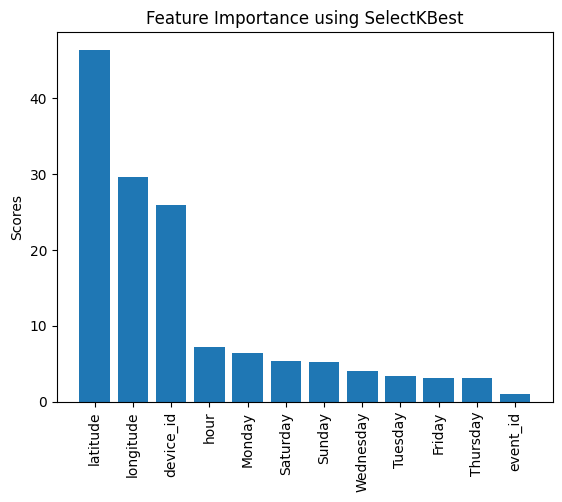

In [60]:
importances = feature_scores.Score
sorted_index=np.argsort(importances)[::-1]
x=range(len(importances))
labels=np.array(feature_scores.iloc[sorted_index].Feature_Name)

plt.rcdefaults()
plt.bar(x,importances[sorted_index],tick_label=labels)
plt.title("Feature Importance using SelectKBest")
plt.ylabel("Scores")
plt.xticks(rotation=90)
plt.show()

###  a. Segmenting the data[Scenario 1]

In [62]:
# Scaling the data
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(X_train)
X_train = pd.DataFrame(scaled_df)
scaled_df = scaler.fit_transform(X_test)
X_test = pd.DataFrame(scaled_df)

The next step is to train and stack some models. Here I use Logistic Regression, RF. The tree models will be stacked using xgboost. In the code below, the models and the stacking classifier are defined first. Then each model is trained using CV.

Finally,the stacking classifier is fitted and predictions are obtained.

### HyperParameters tuning for various Algorithms

In [63]:
hyperparameters = {
    'Random_Forest_Regression': {
        'algorithm': RandomForestRegressor(),
        'parameters': {
            'n_estimators': [50,100, 150, 200,250,300],
            'max_depth': [10, 20, 30],
            'min_samples_split':[2, 4, 8],
            'max_features': [4, 6, 8, 10],
            'min_samples_leaf': [1, 2, 4,6, 8, 10],
            'max_features': ['auto', 'sqrt', 'log2', None]
         }
    }
}

In [64]:
# get the model hyperparameters from the dictionary and execute one by one for finding best hyper parameters
for hyperparam in hyperparameters.values():
    algorithm = hyperparam.get('algorithm')
    parameters = hyperparam.get('parameters')
    grid_search_cv_model = GridSearchCV(estimator=algorithm, param_grid=parameters, cv=3)
    grid_search_cv_model.fit(X_train, y_train)
    print('Algorithm: ' + str(algorithm))
    print('Optimized Parameters: ' + str(grid_search_cv_model.best_params_))
    print("====================================")

### b. Gender and Age Prediction

### Gender Prediction

### Age Prediction

#### 1. Age Prediction Using Regression

##### RMSE

In [66]:
rf_regressor = RandomForestRegressor(max_depth=10, max_features=4, min_samples_leaf=10, n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 8.937342911776064


### R-Squared

In [67]:
# calculate the R-squared score
r2 = r2_score(y_test, y_pred)

print("R-squared score:", r2)

R-squared score: 0.13920855556765255


### Percentage population distribution 

on the train set and test set, which lies between +/- 25% of the actual and predicted value. Let the actual age be A and the predicted age be P.) The error between the actual age and the predicted age is given by the following formula:

    (A−PA)×100

In [68]:
# assume y_test contains the actual age and y_pred contains the predicted age
error = (y_test - y_pred) * 100 / y_test
within_25pct = ((error >= -25) & (error <= 25)).sum() / len(error) * 100

print(f"Percentage of population within +/- 25% of actual age: {within_25pct:.2f}%")


Percentage of population within +/- 25% of actual age: 65.42%


#### Age Prediction Results

In [69]:
y_pred = np.round(y_pred).astype(int)
y_pred

array([34, 32, 34, ..., 31, 33, 35])

### Saving the Model for future use

In [70]:
# # Save the model as a pickle file
with open('scenario1_age_model.pkl', 'wb') as file:
    pickle.dump(rf_regressor, file)